In [25]:
# Load data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.linear_model import LogisticRegression
import project_env
from imp import reload

reload(project_env)

%matplotlib inline

**The `project_env` package**

I wrote this python package so loading and working with data is quicker and easier. There are several convenience methods:
* `load(station_id)` - Given an integer station ID, loads that station data and do all the preprocessing. Returns a `DataFrame`.
* `bucket_y_variable(df, target='y_60m')` - Given a `DataFrame` from `load()`, chooses a target variable. Drops rows that don't have that target variable, and apply thresholding. Returns a `DataFrame` with a `y` column, and all the `y_XYm` columns dropped.
* `split(df)` - Given output of `bucket_y_variable`, splits the `DataFrame` into training, dev (or validation) and test sets. Proportions can be adjusted, default is 0.7/0.2/0.1. The output is a dictionary:
```
  {
    'train': (DataFrame, Series),
    'dev': (DataFrame, Series),
    'test': (DataFrame, Series)
  }
```
  Each `(DataFrame, Series)` tuple is the feature values and target variables, respectively.
* `merge_training(split, df)` - Given the output of `split` and `bucket` (in that order), append *all* the rows in the second argument to the training set of the first argument. This is useful when trying to load data from multiple stations, but testing on one station only.

# of raw records: 4789
           last_reported  num_bikes_available_scaled  day_of_week  \
1379 2016-10-24 17:58:03                    0.196721            0   
2786 2016-11-01 11:14:48                    0.180328            1   
4453 2016-11-09 16:32:40                    0.081967            2   
2654 2016-10-31 17:44:37                    0.459016            0   
3943 2016-11-07 02:00:32                    0.016393            0   
1128 2016-10-23 12:14:32                    0.459016            6   
2575 2016-10-31 10:44:17                    0.360656            0   
4626 2016-11-10 13:44:44                    0.131148            3   
3140 2016-11-02 23:08:48                    0.163934            2   
2023 2016-10-27 22:41:59                    0.885246            3   
1836 2016-10-26 22:04:11                    0.721311            2   
1604 2016-10-25 20:19:46                    0.540984            1   
3993 2016-11-07 13:13:46                    0.000000            0   
3525 2016-1

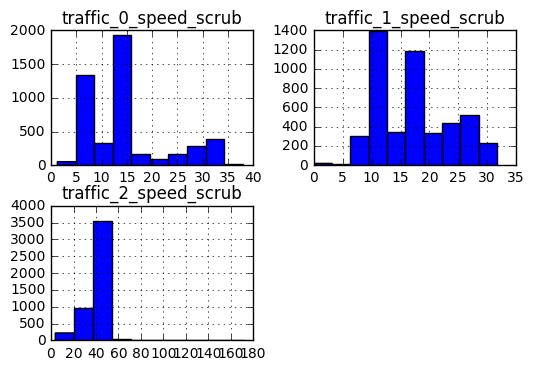

In [2]:
data = project_env.load(519)

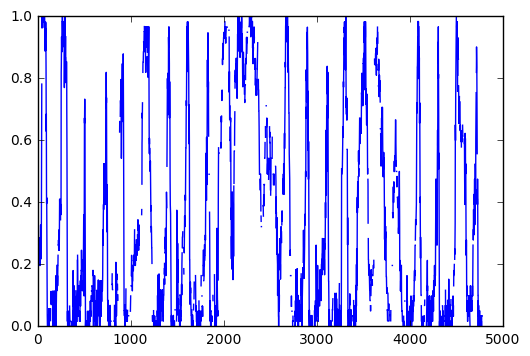

# rows dropped because of missing Y: 957 / 4789


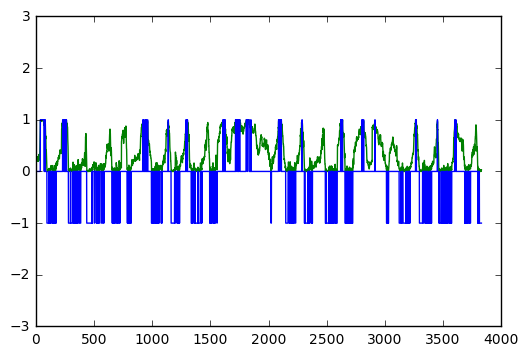

In [5]:
data_519_60m = project_env.bucket_y_variable(data, target='y_60m')

In [6]:
data_519_60m_split = project_env.split(data_519_60m)

(train, dev, test): (2682, 766, 384)


In [7]:
training_X, training_y = data_519_60m_split['train']
dev_X, dev_y = data_519_60m_split['dev']

training_X[:3].T

,0,1,2
apparentTemperature,77.330000,78.040000,78.040000
cloudCover,0.510000,0.250000,0.250000
dewPoint,62.130000,62.260000,62.260000
humidity,0.600000,0.580000,0.580000
nearestStormDistance,16.000000,39.000000,39.000000
ozone,280.780000,280.500000,280.500000
precipIntensity,0.000000,0.000000,0.000000
precipProbability,0.000000,0.000000,0.000000
pressure,1013.380000,1013.280000,1013.280000
temperature,77.330000,78.040000,78.040000


In [14]:
def do_logreg(split_data, squares=False, plot=True):
    train_X, train_y = split_data['train']
    dev_X, dev_y = split_data['dev']
    
    logreg = LogisticRegression(C=1e5)
    scaler = sklearn.preprocessing.StandardScaler()
    train_X_scaled = scaler.fit_transform(train_X)
    
    if squares:
        train_X_scaled = np.concatenate([train_X_scaled, np.square(train_X_scaled)], axis=1)
    print('X shape:', train_X_scaled.shape)
    
    logreg.fit(train_X_scaled, train_y)

    dev_X_scaled = scaler.transform(dev_X)
    if squares:
        dev_X_scaled = np.concatenate([dev_X_scaled, np.square(dev_X_scaled)], axis=1)
        
    dev_pred = logreg.predict(dev_X_scaled)
    acc = sklearn.metrics.accuracy_score(dev_y, dev_pred)
    print('Evaluating on dev set of {} examples'.format(len(dev_y)))
    print('Accuracy:', acc)
    
    print(sklearn.metrics.confusion_matrix(dev_y, dev_pred))

    if plot:
        plt.figure()
        plt.plot(dev_y.as_matrix()[100:500], 'b')
        plt.plot(dev_pred[100:500], 'g')
        plt.plot(0.5 * (dev_y.as_matrix() - dev_pred)[100:500], 'r')
        plt.ylim(-3, 3)
        plt.show()
    
    return logreg, scaler

X shape: (2682, 22)
Evaluating on dev set of 766 examples
Accuracy: 0.718015665796
[[ 20 174   0]
 [ 26 530   6]
 [  0  10   0]]


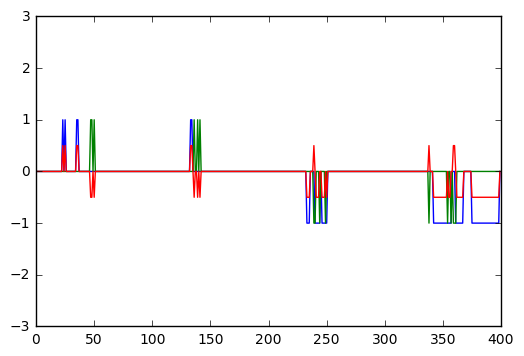

(LogisticRegression(C=100000.0, class_weight=None, dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
 StandardScaler(copy=True, with_mean=True, with_std=True))

In [15]:
do_logreg(data_519_60m_split)

In [16]:
shuffle = project_env.split(data_519_60m, inorder=False)
shuffle['train'][0][:5]

(train, dev, test): (2682, 766, 384)


,apparentTemperature,cloudCover,dewPoint,humidity,nearestStormDistance,ozone,precipIntensity,precipProbability,pressure,temperature,...,windSpeed,num_bikes_available_scaled,num_bikes_disabled_scaled,num_docks_available_scaled,day_of_week,hour_of_day,is_weekend,traffic_0_speed_scrub,traffic_1_speed_scrub,traffic_2_speed_scrub
1579,51.02,0.45,31.19,0.46,33,301.03,0.0,0.0,1024.47,51.02,...,8.82,0.163934,0.032787,0.803279,1,18.233333,0.0,8.080000,24.850000,37.28
212,77.95,0.01,63.44,0.61,44,274.47,0.0,0.0,1011.93,77.95,...,6.18,0.081967,0.000000,0.918033,1,13.650000,0.0,26.100000,18.020000,45.98
1184,61.56,0.23,39.34,0.44,10,268.66,0.0,0.0,1011.42,61.56,...,7.35,0.967213,0.000000,0.032787,6,17.650000,1.0,15.106821,9.940000,42.87
2472,72.64,0.60,58.97,0.62,8,271.30,0.0,0.0,1010.26,72.64,...,2.01,0.622951,0.049180,0.327869,6,15.983333,1.0,15.106821,16.923904,14.91
3020,64.30,0.31,52.82,0.66,205,264.29,0.0,0.0,1023.70,64.30,...,5.17,0.049180,0.000000,0.950820,2,13.150000,0.0,6.210000,16.160000,42.87


X shape: (2682, 22)
Evaluating on dev set of 766 examples
Accuracy: 0.746736292428
[[ 93 101   0]
 [ 55 478   2]
 [  0  36   1]]


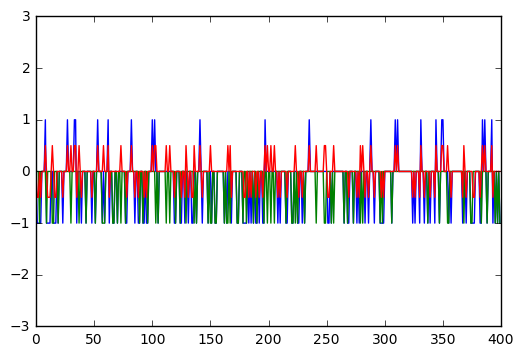

In [17]:
random_logreg, random_scaler = do_logreg(shuffle)

In [18]:
coefs = pd.DataFrame(random_logreg.coef_.T, columns=['empty', 'intermediate', 'full'])
coefs['feature_name'] = training_X.columns
coefs

,empty,intermediate,full,feature_name
0,1.847269,-2.271752,-0.357437,apparentTemperature
1,-0.188398,0.241879,-0.376056,cloudCover
2,0.811690,-1.726082,1.006248,dewPoint
3,-0.317751,0.932199,-1.519086,humidity
4,0.065319,0.038439,-1.812924,nearestStormDistance
5,0.043839,-0.054201,0.893763,ozone
6,0.091503,-0.012789,0.140527,precipIntensity
7,-0.014511,-0.025752,-0.322276,precipProbability
8,-0.068834,-0.096014,0.290525,pressure
9,-2.621878,3.493063,0.199939,temperature


In [28]:
# Add in data from PS south (517) - capacity 59
def read_more_data(station_id):
    dat = project_env.load(station_id, log=False)
    return project_env.bucket_y_variable(dat, target='y_60m', plot=False)

data_cleaned_517 = read_more_data(517)
data_cleaned_517.describe().T

,count,mean,std,min,25%,50%,75%,max
apparentTemperature,2063.0,57.255468,10.696980,37.26,50.430000,56.300000,65.710000,84.620000
cloudCover,2063.0,0.322787,0.288933,0.00,0.090000,0.240000,0.500000,1.000000
dewPoint,2063.0,44.408347,11.811946,26.27,34.615000,42.180000,55.180000,68.490000
humidity,2063.0,0.617654,0.138268,0.35,0.510000,0.610000,0.700000,0.950000
nearestStormDistance,2063.0,85.552593,143.622552,0.00,8.000000,20.000000,94.000000,829.000000
ozone,2063.0,279.019636,13.829284,246.79,270.150000,276.660000,287.100000,314.970000
precipIntensity,2063.0,0.001110,0.007539,0.00,0.000000,0.000000,0.000000,0.210300
precipProbability,2063.0,0.047552,0.205358,0.00,0.000000,0.000000,0.000000,1.000000
pressure,2063.0,1017.810368,20.158800,521.67,1013.050000,1019.830000,1023.590000,1031.170000
temperature,2063.0,57.983010,9.715366,40.95,50.430000,56.300000,65.710000,83.620000


(train, dev, test): (800, 0, 0)
X shape: (3482, 22)
Evaluating on dev set of 766 examples
Accuracy: 0.745430809399
[[ 84 110   0]
 [ 47 486   2]
 [  0  36   1]]


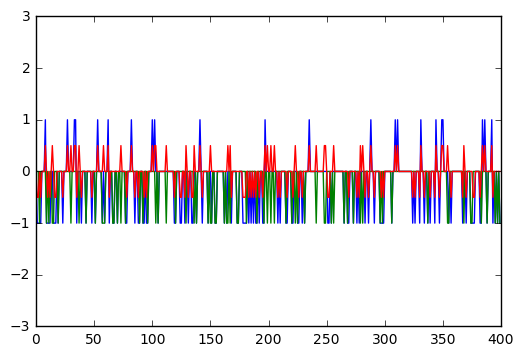

In [34]:
appended = project_env.merge_training(shuffle, data_cleaned_517[:800])

a_random_logreg, a_random_scaler = do_logreg(appended)

In [30]:
# Go nuts with adding more training data.
station_ids_to_concat = [517, 320, 3263, 285, 435, 477]
station_ids_data = [read_more_data(sid) for sid in station_ids_to_concat]

In [35]:
app_len = len(appended['train'][0])
more_appended = appended
for df in station_ids_data:
    half_len = len(df) // 2
    more_appended = project_env.merge_training(more_appended, df[:half_len])
    
assert len(appended['train'][0]) == app_len

(train, dev, test): (1031, 0, 0)
(train, dev, test): (2094, 0, 0)
(train, dev, test): (2112, 0, 0)
(train, dev, test): (1828, 0, 0)
(train, dev, test): (1831, 0, 0)
(train, dev, test): (1669, 0, 0)


X shape: (14047, 44)
Evaluating on dev set of 766 examples
Accuracy: 0.771540469974
[[110  84   0]
 [ 60 474   1]
 [  0  30   7]]


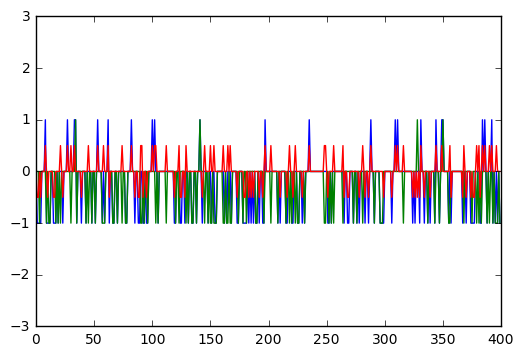

In [36]:
sq, scl = do_logreg(more_appended, squares=True)

In [37]:
coefs = pd.DataFrame(sq.coef_.T, columns=['empty', 'intermediate', 'full'])
coefs['feature_name'] = list(training_X.columns) + [f + '^2' for f in training_X.columns]
coefs.sort_values(by=['full'], inplace=True)
coefs

,empty,intermediate,full,feature_name
0,2.381083,0.845261,-2.090787,apparentTemperature
7,-0.159846,0.738164,-1.744191,precipProbability
10,-0.329896,0.668790,-1.153585,visibility
3,2.091371,0.450236,-1.151921,humidity
15,2.987830,0.586337,-1.004358,num_docks_available_scaled
40,-0.835956,0.549631,-0.654820,is_weekend^2
39,0.374002,-0.050645,-0.519083,hour_of_day^2
25,-0.371272,0.236119,-0.480096,humidity^2
43,-0.033199,0.082184,-0.418614,traffic_2_speed_scrub^2
8,0.419670,-0.134213,-0.351643,pressure
